In [1]:
from datetime import datetime
print(f'Päivitetty {datetime.now().date()} / Aki Taanila')

Päivitetty 2025-02-26 / Aki Taanila


# Aikasarjaennustaminen - eri menetelmien kokeilua

### Ennustemenetelmien taustoja kannattaa opiskella osoitteessa https://otexts.com/fpp3/.

**Nixtla** https://www.nixtla.io/open-source mahdollistaa kehittyneiden ennustemenetelmien käytön myös aloittelevalle ennustajalle. 

Tässä muistiossa käytän Nixtlan **statsforecast**-kirjastoa https://github.com/Nixtla/statsforecast. Minicondan ja Anacondan käyttäjät voivat asentaa kirjaston komentorivillä komennolla `conda install -c conda-forge statsforecast`. Muut voivat asentaa kirjaston komennolla `pip install statsforecast`.

In [2]:
import pandas as pd

from statsforecast import StatsForecast

# Käytettävien mallien tuonti
from statsforecast.models import HoltWinters, AutoARIMA, AutoETS

# Mallien vertailuun
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

# Seuraava asetus sijoittaa tulostaulukoissa tunnistetiedot (id) omaksi muuttujakseen indeksin sijasta
# Ilman asetusta kaikki toimii, mutta ei välttämättä tulevissa versioissa
import os
os.environ['NIXTLA_ID_AS_COL'] = '1'

## Aikasarjan valmistelu

Statsforecast-kirjastoa käytettäessä datasta täytyy löytyä muuttujat: 

* **unique_id** aikasarjan yksilöivä tunniste
* **ds** aikaleimat, joiden sijasta voidaan käyttää myös juoksevaa numerointia
* **y** aikasarjan arvot.

In [3]:
df = pd.read_csv('https://taanila.fi/beer.csv')
df

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9
...,...,...
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0


In [4]:
# Muunnetaan aikasarja statsdorecast-kirjaston edellyttämään muotoon
df['unique_id'] = 'Beer production'
df['ds'] = pd.to_datetime(df['Month'], format='%Y-%m')
df = df.drop('Month', axis=1)
df = df.rename(columns={'Monthly beer production':'y'})
df = df[['unique_id', 'ds', 'y']]
df.head()

,unique_id,ds,y
0,Beer production,1956-01-01,93.2
1,Beer production,1956-02-01,96.0
2,Beer production,1956-03-01,95.2
3,Beer production,1956-04-01,77.1
4,Beer production,1956-05-01,70.9


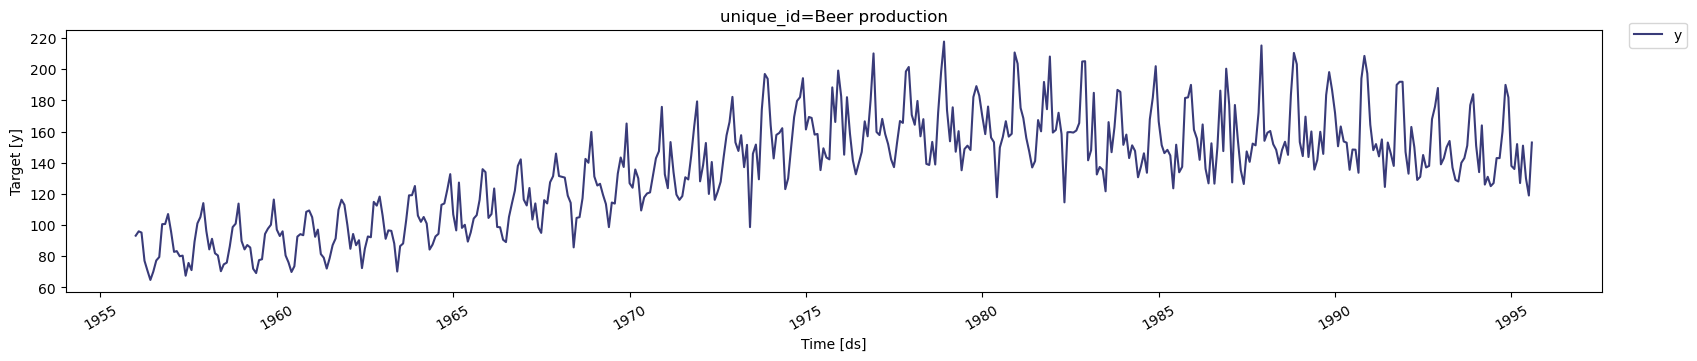

In [5]:
# Tarkistetaan miltä aikasarja näyttää grafiikkana
StatsForecast.plot(df)

## Mallit

Seuraavassa kokeilen kolmea statsforecast-kirjaston mallia

* **HoltWinters**, joka huomioi trendin ja kausivaihtelun. En määrittele etukäteen käsitelläänkö virheitä, trendiä ja kausivaihtelua additiivisesti (summamalli) vai multiplikatiivisesti (tulomalli), vaan annan algoritmin valita sopivimmat parametrit.
* **AutoARIMA**, joka kokeilee erilaisia parametrien kombinaatioita ja valitsee niistä sopivimman **AICc**-informaatiokriteerin perusteella. Lisätietoa https://otexts.com/fpp3/arima-estimation.html#information-criteria
* **AutoETS**, joka etsii sopivimmat parametrit eksponentiaalista tasoitusta käyttävälle ETS-mallille käyttäen **AICc**-informaatiokriteeriä. Lisätietoa https://otexts.com/fpp3/ets-estimation.html#model-selection. ETS-malleissa aikasarjasta erotetaan kolme komponenttia (E=error, T=trend, S=seasonal). HoltWinters on myös ETS-malli, mutta mallin parametrien määrittämiseen käytetään käsittääkseni AICc-informaatiokriteerin sijasta Maximum-likelihood-menetelmää.

In [6]:
# Luodaan lista käytettävistä malleista
# Kyse on kuukausittaisesta datasta, joten vuotuisen kausivaihtelun jakson pituus on 12
models = [
    AutoETS(season_length=12),
    AutoARIMA(season_length=12),
    HoltWinters(season_length=12)
]

Seuraavassa solussa luodaan StatsForecast-olio:

* **models**-parametrille annetaan arvoksi edellä määritelty lista käytettävistä malleista
* **freq**-parametrin arvon täytyy vastata ds-sarakkeen aikaleimoja; eri vaihtoehtoja löydät osoitteesta https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases. Tässä aikaleimat ovat kuukauden ensimmäisiä päivä, jota edustaa **'MS'** (Month Start)
* **n_jobs**-parametrin arvo -1 määrittää että käytetään mahdollisuuksien mukaan kaikkia prosessorin ytimiä rinnakkaisprosessointiin

In [7]:
sf = StatsForecast( 
    models=models,
    freq='MS', 
    n_jobs=-1,
)

## Ennusteet luottamusväleineen

Statsforecast-kirjaston **forecast**-funktio on nopein tapa ennusteiden laskemiseen. Mallia ei tarvitse erikseen sovittaa ennen funktion käyttöä.

In [8]:
# Mallien antamat ennusteet ja 90 % luottamusvälit 48 kuukautta eteenpäin
forecasts_df = sf.forecast(df=df, h=48, level=[90])
forecasts_df

,unique_id,ds,AutoETS,AutoETS-lo-90,AutoETS-hi-90,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90
0,Beer production,1995-09-01,136.591109,121.173070,152.009148,136.977579,120.999546,152.955611,136.559771,118.886691,154.232852
1,Beer production,1995-10-01,162.907029,144.495872,181.318186,160.024084,143.986919,176.061249,163.381287,145.681898,181.080676
2,Beer production,1995-11-01,175.623253,155.742650,195.503855,181.708861,165.516505,197.901217,176.524952,158.791150,194.258753
3,Beer production,1995-12-01,184.609877,163.670739,205.549015,185.109415,168.645678,201.573153,185.099105,167.322119,202.876092
4,Beer production,1996-01-01,148.095326,131.178001,165.012650,146.675921,130.155903,163.195940,148.122215,130.292725,165.951705
5,Beer production,1996-02-01,138.495668,122.569776,154.421560,137.456105,120.831432,154.080778,138.497640,120.605901,156.389380
6,Beer production,1996-03-01,153.136598,135.507722,170.765474,153.082246,136.370102,169.794391,153.460597,135.496541,171.424654
7,Beer production,1996-04-01,138.707911,122.570874,154.844947,136.594915,119.790813,153.399017,138.911381,120.864719,156.958042
8,Beer production,1996-05-01,136.770760,120.736346,152.805174,138.545416,121.651394,155.439438,137.239180,119.099493,155.378868
9,Beer production,1996-06-01,123.713137,108.961802,138.464473,124.590741,107.606802,141.574679,124.202077,105.958896,142.445258


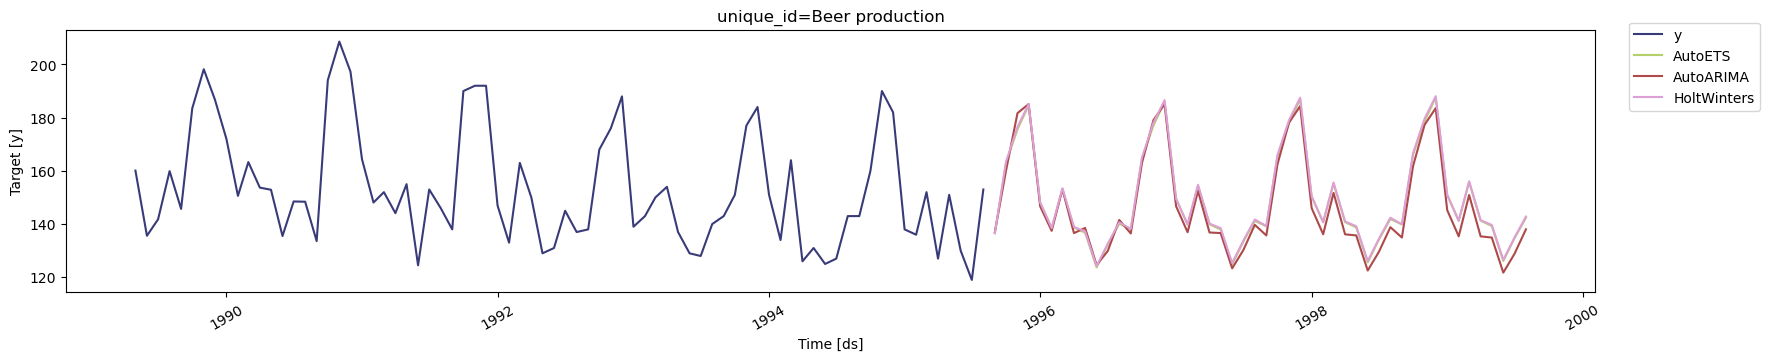

In [9]:
# Tässä piirretään kolmen mallin antamat ennusteet päällekkäin samaan kaavioon
sf.plot(df[400:], forecasts_df)

## Mallien arviointia

Malleja voidaan arvoida **cross_validation**-funktiolla. Käytän tässä cross_validation-funtiota yksinkertaisimmalla mahdollisella tavalla, jossa viimeisen vuoden tietoja käytetään testidatana. Parametrien arvoja:

* h=12 tarkoittaa sovitettujen arvojen laskemista 12 kuukaudelle kerrallaan
* n_windows=1 rajoittaa sovitettujen arvojen laskemisen viimeisen 12 kuukauden ajalle.

In [10]:
crossvalidation_df = sf.cross_validation(
    df=df,
    h=12,
    n_windows=1
)

In [11]:
# Sovitetut arvot eri menetelmillä viimeisille 12 kuukaudelle
crossvalidation_df

,unique_id,ds,cutoff,y,AutoETS,AutoARIMA,HoltWinters
0,Beer production,1994-09-01,1994-08-01,143.0,138.315271,132.841527,133.369258
1,Beer production,1994-10-01,1994-08-01,160.0,158.139011,163.283956,160.591800
2,Beer production,1994-11-01,1994-08-01,190.0,166.895708,176.568921,171.244265
3,Beer production,1994-12-01,1994-08-01,182.0,178.559072,183.942215,181.761614
4,Beer production,1995-01-01,1994-08-01,138.0,147.811684,148.654907,145.549172
5,Beer production,1995-02-01,1994-08-01,136.0,138.353336,133.117235,134.750680
6,Beer production,1995-03-01,1994-08-01,152.0,149.104532,150.319267,149.073487
7,Beer production,1995-04-01,1994-08-01,127.0,134.579211,132.998696,135.473489
8,Beer production,1995-05-01,1994-08-01,151.0,129.997769,132.000720,130.454322
9,Beer production,1995-06-01,1994-08-01,130.0,115.893457,118.416622,118.099244


Parhaan mallin valitsemiseen käytän seuraavassa virheiden neliöiden keskiarvoa (**mse** = mean squared error):

In [12]:
# Lista käytetyistä malleista
models_list = crossvalidation_df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.to_list()
# Mallien arviointi mse:n avulla
evaluation_df = evaluate(crossvalidation_df, metrics=[mse], models=models_list)
# Parhaan mallin tunnistaminen
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
evaluation_df

,unique_id,metric,AutoETS,AutoARIMA,HoltWinters,best_model
0,Beer production,mse,156.669033,122.206573,135.619141,AutoARIMA


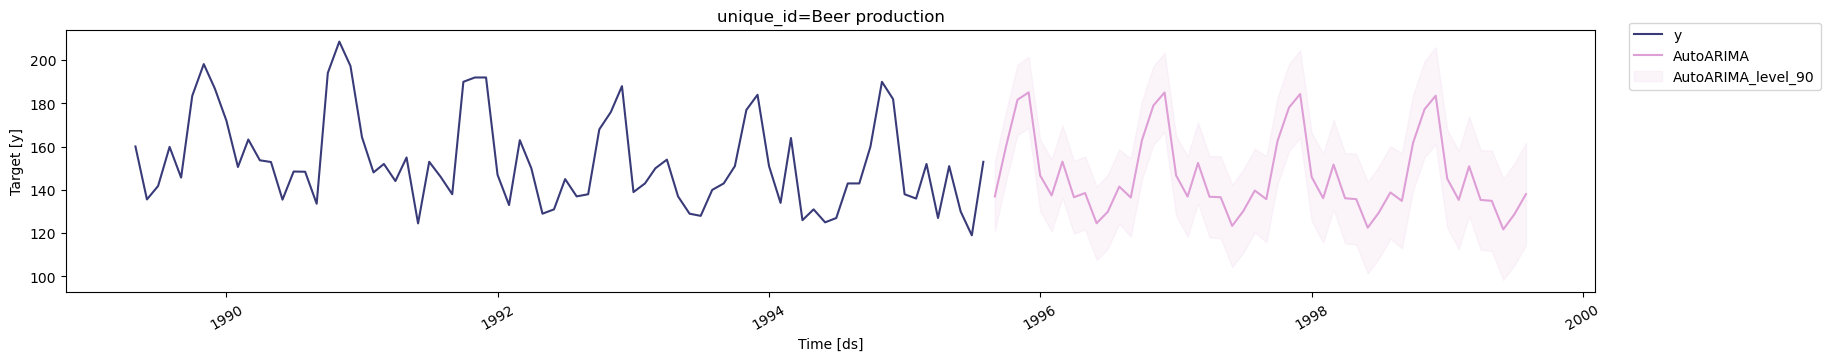

In [13]:
# Paras malli luottamusväleineen (90 %) grafiikkana
sf.plot(df[400:], forecasts_df, models=[evaluation_df.loc[0, 'best_model']], level=[90])

Katsotaan parasta mallia vielä hieman tarkemmin sovittamalla malli **fit**-funktiolla. Parametrin **trace=True** ansiosta näen kokeillut mallit ja niiden **AICc**-arvot (informaatiokriteeri, jonka perusteella malli on valittu). 

In [14]:
sf_final = StatsForecast( 
    models=[AutoARIMA(season_length=12, trace=True)],
    freq='MS', 
    n_jobs=-1,
)
sf_final.fit(df)


ARIMA(2,1,2)(1,1,1)[12]                   :3446.546233137568

ARIMA(0,1,0)(0,1,0)[12]                   :4010.5665523478647

ARIMA(1,1,0)(1,1,0)[12]                   :3816.5882564018343

ARIMA(0,1,1)(0,1,1)[12]                   :3483.733861632553

ARIMA(2,1,2)(0,1,1)[12]                   :3452.754103314731

ARIMA(2,1,2)(1,1,0)[12]                   :3552.308784748779

ARIMA(2,1,2)(2,1,1)[12]                   :3447.4817232081014

ARIMA(2,1,2)(1,1,2)[12]                   :3447.402623448583

ARIMA(2,1,2)(0,1,0)[12]                   :3626.483023482437

ARIMA(2,1,2)(0,1,2)[12]                   :3451.1129228588597

ARIMA(2,1,2)(2,1,0)[12]                   :3519.392260794897

ARIMA(2,1,2)(2,1,2)[12]                   :3449.175464507052

ARIMA(1,1,2)(1,1,1)[12]                   :3447.1945193299175

ARIMA(2,1,1)(1,1,1)[12]                   :3452.034753852461

ARIMA(3,1,2)(1,1,1)[12]                   :3448.027166865179

ARIMA(2,1,3)(1,1,1)[12]                   :inf

ARIMA(1,1,1)(1,1

StatsForecast(models=[AutoARIMA])

Edellisen perusteella malliksi valikoitui **ARIMA(1, 1, 3)(1, 1, 1)[12]**, koska sen kohdalla **AICc** arvo oli pienin.

Kausivaihtelun huomioivassa ARIMA-mallissa ensimmäinen lukukolmikko liittyy aikasarjan perusvaihteluun (poislukien kausivaihtelu) ja toinen lukukolmikko liittyy kausivaihteluun. Viimeisin luku (12) kertoo kausivaihelun pituuden (tässä kausivaihelu toistuu 12 kuukauden jaksoissa).

Lukukolmikot saavat selityksensä mallin rakenteesta. ARIMA on lyhenne nimestä **AutoRegressive Integrated Moving Average** eli mallissa on kolme osaa, joita seuraavassa yritän yksinkertaistaen hahmottaa:

* **AutoRegressive**: Aikasarjaennustamisessa arvoja ennustetaan aiempien arvojen perusteella. Tämä on perusteltua, jos aikasarjan arvot korreloivat aiempien arvojen kanssa (tätä kutsutaan autokorrelaatioksi). Autoregressio-luku kertoo kuinka monta havaintoa taaksepäin otetaan mukaan regressiomalliin. Esimerkissämme perusvaihtelun osalta otetaan mukaan kolme havaintoa taaksepäin. Kausivaihelun kohdalla tarkoitetaan edellisten kausivaihtelujaksojen vastaavan ajankohdan havaintoja. Esimerkissämme kausivaihteluun liittyvä autoregressio-luku on nolla (0).
* **Integrated**: ARIMA-mallia käytettäessä aikasarjan pitäisi olla stationaarinen, joka yksinkertaistettuna tarkoittaa että keskiarvo ja keskihajonta pysyvät ajankuluessa kuta kuinkin vakioina. Ei-stationaarinen aikasarja muutetaan stationaariseksi vähentämällä aikasarjan arvosta aiempi arvo (lasketaan aikasarjassa tapahtunut muutos). Integrated-luku kertoo kuinka monta kertaa tämä toimenpide täytyy toistaa aikasarjan muuttamiseksi stationaariseksi. Esimerkissämme vähentäminen tehdään kerran sekä perusvaihtelun että kausivaihtelun osalta. 
* **Moving Average**: Liukuvien keskiarvojen avulla voidaan tunnistaa lyhyen aikavälin trendejä. Moving Average -luku kertoo kuinka monen aiemman havainnon liukuvia keskiarvoja lasketaan. Tarkkaan ottaen ARIMA-mallissa lasketaan liukuvia keskiarvoja virhetermeistä. Perusvaihtelun osalta lasketaan kolmen havainnon liukuvia keskiarvoja ja kausivaihtelun osalta kahden havainnon liukuvia keskiarvoja.


Vilkaistaan vielä lopuksi kahta muuta mallia sovittamalla mallit ja katsomalla minkälaiset komponentit niihin valikoitui.

In [15]:
sf_holtwinter = StatsForecast( 
    models=[HoltWinters(season_length=12)],
    freq='MS', 
    n_jobs=-1,
)
sf_holtwinter.fit(df)

# Tätä ei statsforecast-kirjaston dokumentaatiosta löytynyt, mutta näin mallin komponentit saa selville:
sf_holtwinter.fitted_[0, 0].model_['components']

'AAAD'

ETS-mallin komponentti voi olla additiivinen (A), multiplikatiivinen (M) tai puuttua kokonaan (N). Edellä mallin komponentit ovat:

* Additiivinen virhetermi
* Additiivinen trendi
* Additiivinen kausivaihtelu
* Viimeisen kirjaimen (D) selitystä en ole löytänyt, mutta se voisi tarkoittaa vaimennettua (damped) trendiä?

In [16]:
sf_autoets = StatsForecast( 
    models=[AutoETS(season_length=12)],
    freq='MS', 
    n_jobs=-1,
)
sf_autoets.fit(df)

# Tätä ei statsforecast-kirjaston dokumentaatiosta löytynyt, mutta näin mallin komponentit saa selville:
sf_autoets.fitted_[0, 0].model_['components']

'MAAD'

Mallin komponentit ovat siis seuraavat:

* Multiplikatiivinen virhetermi
* Additiivinen trendi
* Additiivinen kausivaihtelu
* Viimeisen kirjaimen (D) selitystä en ole löytänyt, mutta se voisi tarkoittaa vaimennettua (damped) trendiä?

## Lisätietoa

Nixtlan sivuilta löydät pidemmälle menevän esimerkin, jossa usean mallin lisäksi on samanaikaisesti mukana useita aikasarjoja:
https://nixtlaverse.nixtla.io/statsforecast/docs/getting-started/getting_started_complete.html